Librerias

In [106]:
import os
import scipy.io
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

#CNN
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Dropout

In [107]:
import numpy as np
import pickle
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [108]:
ruta = "datos mat\Done"

In [109]:
# Parámetros del modelo
input_shape=(385,16)
optimizer_params = {
    'learning_rate': 0.0001,    'beta_1': 0.9,    'beta_2': 0.999,    'epsilon': 1e-07,
    'amsgrad': False,    'weight_decay': None,    'clipnorm': None,    'clipvalue': None,
    'global_clipnorm': None,
    'use_ema': False,
    'ema_momentum': 0.99,
    'ema_overwrite_frequency': None,
    'loss_scale_factor': None,
    'gradient_accumulation_steps': None,
    'name': "adam"
}

Funciones

In [110]:
def get_event_sujxrun(ruta, sujeto):
    eventos_por_mark = {}

    for subject in os.listdir(ruta):
        if f"Subject {sujeto}" in subject:
            ruta_subj = os.path.join(ruta, subject)
            archivos_suj = os.listdir(ruta_subj)

            for run in range(1, 9):  # Iterar sobre los 8  runs
                for suj in archivos_suj:
                    if f"run_{run}" in suj:  # Corregido para iterar sobre todos los runs
                        ruta_suj = os.path.join(ruta_subj, suj)
                        archivos_mark = os.listdir(ruta_suj)

                        for mark in archivos_mark:
                            ruta_mark = os.path.join(ruta_suj, mark)
                            archivos_event = os.listdir(ruta_mark)

                            for event in archivos_event:
                                ruta_evento = os.path.join(ruta_mark, event)
                                mat_data = loadmat(ruta_evento)
                                eeg_processed = mat_data.get('eeg_processed')
                                eeg_processed_tensor = tf.convert_to_tensor(eeg_processed)
                                if eeg_processed.shape == (385, 16):
                                    if mark not in eventos_por_mark:
                                        eventos_por_mark[mark] = []
                                    eventos_por_mark[mark].append(eeg_processed)
                                    
   
    return eventos_por_mark 

In [111]:
def datos_x_suj(suj):
    events_suj = get_event_sujxrun(ruta, f"{suj}")
    markers = {"Marker_1": [], "Marker_2": [], "Marker_3": [], "Marker_4": [], "Marker_5": [], "Marker_6": []}
    length_datos = {mark: 0 for mark in events_suj}
    
    for mark, value in events_suj.items():
        if mark in markers:
            markers[mark].extend(value)  
            length_datos[mark] += len(value)
    
    tensorxsuj={}
    
    for key, value in markers.items():
        tensorxsuj[key] = tf.reshape(tf.convert_to_tensor(value), (length_datos[key], 385, 16))
        
    return tensorxsuj, length_datos

In [112]:
def agrupar_all_suj():
    all_markers = None
    all_lengths = {}
    
    for suj in range(1, 7):
        tensorxsuj, length_datos = datos_x_suj(suj)
        
        for marker, tensor in tensorxsuj.items():
            if all_markers is None:
                all_markers = tensor
            else:
                all_markers = tf.concat([all_markers, tensor], axis=0)
            if marker in all_lengths:
                all_lengths[marker] += length_datos[marker]
            else:
                all_lengths[marker] = length_datos[marker]
    
    return all_markers, all_lengths

In [113]:
all_markers, all_lengths = agrupar_all_suj()
print(all_markers.shape)
print(all_lengths)

(2956, 385, 16)
{'Marker_1': 480, 'Marker_2': 509, 'Marker_3': 522, 'Marker_4': 523, 'Marker_5': 527, 'Marker_6': 395}


In [114]:
all_lengths

{'Marker_1': 480,
 'Marker_2': 509,
 'Marker_3': 522,
 'Marker_4': 523,
 'Marker_5': 527,
 'Marker_6': 395}

In [115]:
def all_labels():
    labels_market = {
        "Marker_1": [1, 0, 0, 0, 0, 0],
        "Marker_2": [0, 1, 0, 0, 0, 0],
        "Marker_3": [0, 0, 1, 0, 0, 0],
        "Marker_4": [0, 0, 0, 1, 0, 0],
        "Marker_5": [0, 0, 0, 0, 1, 0],
        "Marker_6": [0, 0, 0, 0, 0, 1]
    }
    
    n_label=[]
    for marker, value in all_lengths.items():  
        label_m = labels_market.get(marker)
        
        labels = [label_m] * value
        for i in labels:
            n_label.append(i)

    return n_label

In [116]:
all_labels()

[[1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0,

In [117]:
labels_usar= np.array(all_labels())
inputs_usar= all_markers

In [118]:
def save_array_as_pkl(array,filename):
    with open(filename, 'wb') as f:
        pickle.dump(array,f)
    print(f"Array saved  {filename}")
    return array

In [119]:
def load_array_from_pkl(filename):
    with open(filename, 'rb') as f:
        array = pickle.load(f)
    print(f"Array loaded from {filename}")
    return array

In [120]:
all_markers, all_lengths = agrupar_all_suj()
B,T,C = all_markers.shape 
all_markers = all_markers.numpy()

In [121]:
save_array_as_pkl(all_markers, f"K_B{B}_T{T}_C{C}_TRAIN.pkl")
save_array_as_pkl(labels_usar, f"K_B{B}_T{T}_C{C}_LABELS.pkl")

Array saved  K_B2956_T385_C16_TRAIN.pkl
Array saved  K_B2956_T385_C16_LABELS.pkl


array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [122]:
#label = load_array_from_pkl("TOMAS_B2956_T385_C16_LABELS.pkl")
#data = load_array_from_pkl("TOMAS_B2956_T385_C16_TRAIN.pkl")

MODELO CONV1D

In [123]:
import numpy as np
from sklearn.model_selection import train_test_split

label = load_array_from_pkl("K_B2956_T385_C16_LABELS.pkl")
data = load_array_from_pkl("K_B2956_T385_C16_TRAIN.pkl")
# Dividir los datos en conjuntos de entrenamiento y prueba
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    data, label, test_size=0.2)


Array loaded from K_B2956_T385_C16_LABELS.pkl
Array loaded from K_B2956_T385_C16_TRAIN.pkl


In [124]:
# Check shapes of training data
print(f'train_inputs shape: {train_inputs.shape}')
print(f'train_labels shape: {train_labels.shape}')

# Check shapes of validation data (optional but good practice)
print(f'val_inputs shape: {val_inputs.shape}')
print(f'val_labels shape: {val_labels.shape}')

train_inputs shape: (2364, 385, 16)
train_labels shape: (2364, 6)
val_inputs shape: (592, 385, 16)
val_labels shape: (592, 6)


RED SIMPLE

In [125]:
#LSTM #arcivo picol, m° total,385 16 canales + labels
#utilizar un modelo con canalees que teno es 16 y eso se transforma en caracteristicas

In [126]:

from keras.optimizers import Adam

optimizer = Adam(**optimizer_params)

model_ss = models.Sequential([
    layers.Conv1D(16, 3, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(6, activation='softmax')])
    
model_ss.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    

In [127]:
model_ss.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 383, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 191, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │        24,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,294 (98.80 KB)

 Trainable params: 25,294 (98.80 KB)

 Non-trainable params: 0 (0.00 B)

In [128]:
history_ss = model_ss.fit(train_inputs, train_labels, epochs=50, batch_size=32,shuffle=True, validation_data=(val_inputs, val_labels))

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2034 - loss: 1.7999 - val_accuracy: 0.2128 - val_loss: 1.7615
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2046 - loss: 1.7674 - val_accuracy: 0.2652 - val_loss: 1.7308
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2283 - loss: 1.7365 - val_accuracy: 0.2821 - val_loss: 1.7064
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2598 - loss: 1.7018 - val_accuracy: 0.3277 - val_loss: 1.6732
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2878 - loss: 1.6761 - val_accuracy: 0.3429 - val_loss: 1.6468
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2777 - loss: 1.6558 - val_accuracy: 0.3733 - val_loss: 1.6218
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3143 - loss: 1.6406 - val_accuracy: 0.3733 - val_loss: 1.6039
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2968 - loss: 1.6098 - val_accuracy: 0.3919 - val_loss

In [129]:
#rendimiento del modelo con shuffle red simple
print("Rendimiento del modelo con shuffle Red Simple")
test_loss, test_accuracy = model_ss.evaluate(val_inputs, val_labels) 
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

Rendimiento del modelo con shuffle Red Simple
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6553 - loss: 0.9672 
Test accuracy: 0.6334459185600281
Test loss: 0.9922006130218506


In [130]:
def plot_training_historyss(history_ss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot training & validation accuracy and loss values from history and history_s
    ax1.plot(history_ss.history['accuracy'], label='Train Accuracy (Shuffle)', color='blue')
    ax1.plot(history_ss.history['val_accuracy'], label='Val Accuracy (Shuffle)', color='orange')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')


    ax2.plot(history_ss.history['loss'], label='Train Loss (Shuffle)', color='red')
    ax2.plot(history_ss.history['val_loss'], label='Val Loss (Shuffle)', color='orange')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')
    

    # Show the plot
    plt.tight_layout()
    plt.show()

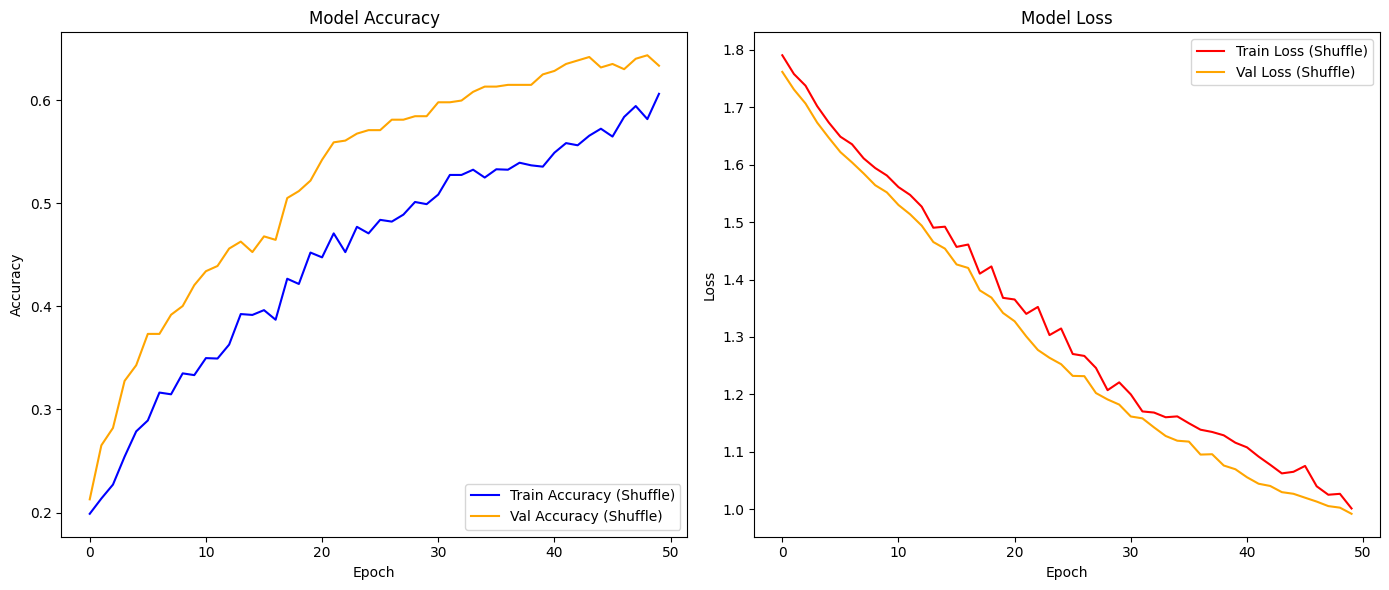

In [131]:
plot_training_historyss(history_ss)